# Investigation of houseprices of cottage

Imports and set magics:

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
from dataproject import NyboligScraper
from dataproject import NyboligAnalysis


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scraping data

First we need to scrape the data from the internet. The data is scraped from https://www.nybolig.dk/. To know how many pages is possible to scrape you can call the get_pages function of the following property types:

**All**: ''
**Andelsbolig**: 'andelsbolig'
**Ejerlejlighed**: 'ejerlejlighed'
**Sommerhusgrunde**: 'fritidsgrund'
**Grunde**: 'helaarsgrund'
**Hus**: 'hus'
**Landejendomme**: 'landejendom'
**Rækkehuse**:  'raekkehus'
**Sommerhuse**: 'sommerhus'
**Villalejligheder**:   'villalejlighed'


The number of pages that you choose will determine the size of the dataset.

In [38]:
scraper = NyboligScraper()
scraper.get_pages(property_type='')


Total number of pages: 2223


Next, we need to identify what property types and how many pages we want to work with. To do this you can call the scraper.scrape_data_nybolig(self, num_pages, property_type=None, file_name=None) function. This will save the desired data into a CSV file that we will be able to work with.

In [39]:
scraper.scrape_data_nybolig(num_pages=5, property_type='sommerhus', file_name='dataprojekt_data')

# Accessing Data

Now that we have created the dataset we need to access it. To do this please provide the path of this dictionary with the filename.

In [40]:
file_path = 'dataprojekt_data.csv'
data = pd.read_csv('dataprojekt_data.csv')
print(data.head())


                                    address   postcode        city    price  \
0              Vandflodvej 25, 6857 Blåvand       6857     Blåvand  3395000   
1  Drejet 36D, Spodsbj Drej, 5900 Rudkøbing       5900   Rudkøbing  1845000   
2  Marielyst Strandpark 46, 4873 Væggerløse       4873  Væggerløse  1995000   
3                     Dillet 7, 4874 Gedser       4874      Gedser  1775000   
4             Hjelmvej 13, Elsegårde Strand  Elsegårde      Strand  1298000   

           type  rooms  size_1  size_2  
0  Fritidsbolig      5     178     NaN  
1  Fritidsbolig      4      83     NaN  
2  Fritidsbolig      5     115     NaN  
3  Fritidsbolig      4      85     NaN  
4  Fritidsbolig      3      40     NaN  


# Analysis

In [41]:
analysis = NyboligAnalysis(file_path)

In [42]:
analysis.descriptive_statistics('price')

,count,mean,std,min,25%,50%,75%,max
price,99,2.308273e+06,1.749475e+06,545000,1287500.0,1795000.0,2572500.0,11800000


# How does location affect the price?

Mean price for each city

In [43]:
# Group the data by city and calculate the mean price
mean_prices_by_city = data.groupby('city')['price'].mean().reset_index()
mean_prices_by_city = mean_prices_by_city.sort_values('price', ascending=False)


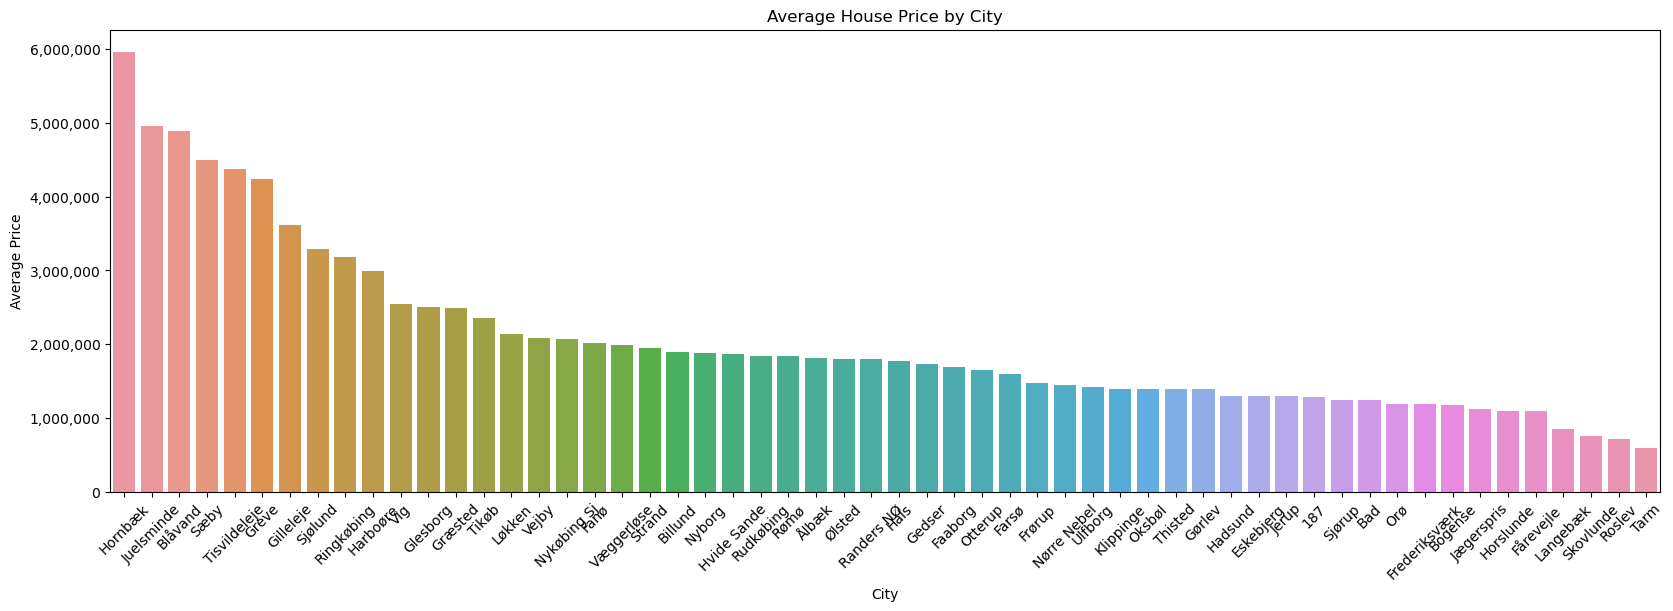

In [44]:
from matplotlib.ticker import FuncFormatter

def price_formatter(x, _):
    return f'{int(x):,}'

formatter = FuncFormatter(price_formatter)

plt.figure(figsize=(20, 6))
ax = sns.barplot(x='city', y='price', data=mean_prices_by_city)
plt.title('Average House Price by City')
plt.xticks(rotation=45)
plt.ylabel('Average Price')
plt.xlabel('City')

ax.yaxis.set_major_formatter(formatter)
plt.show()


From this we can see that the cities with the highest average house price are Hornbæk, Jules minde and Blåvand and we see the cities with the lowest average house prices are Tarm, Roslev and Skovlunde.

To analyse how size and rooms affect the price and how much of this variation they are responsible of we will perform af OLS regression.

# OLS Regression

In this section, we analyze the results of an Ordinary Least Squares (OLS) regression performed on house price data. The dependent variable is the house price, while the independent variables are size (size_1) and the number of rooms (rooms). The OLS regression model helps us understand how house prices are affected by these two factors and how much of the variation in the prices these two variable can explain.

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

file_path = 'dataprojekt_data.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['price', 'size_1', 'rooms'])

X = data[['size_1', 'rooms']]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant term to the independent variables matrix for the intercept
X_train = sm.add_constant(X_train)

# Fit the OLS model
model = sm.OLS(y_train, X_train).fit()


In [46]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     13.20
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           1.20e-05
Time:                        13:47:04   Log-Likelihood:                -1241.5
No. Observations:                  79   AIC:                             2489.
Df Residuals:                      76   BIC:                             2496.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.147e+05   7.15e+05      0.859      0.3


The R-squared value is 0.258, which implies that the model explains only 25.8% of the variation in house prices. This relatively low value indicates that there are other factors that contribute to the variation in house prices that are not captured by our model. The adjusted R-squared value, which takes into account the number of predictors in the model, is 0.238.

The F-statistic is 13.20 with a probability (p-value) of 1.20e-05. Since the p-value is very low (less than 0.05), we can reject the null hypothesis and conclude that at least one of the independent variables (size or rooms) has a significant effect on the house prices.



Coeffient analysis

Size (size_1):

The coefficient for size is 2.641e+04 with a standard error of 7121.086. The t-statistic is 3.709, and the p-value is less than 0.05, indicating that the relationship between size and house price is statistically significant. This result suggests that, on average, an increase of one square meter in size results in an increase of 26,410 in house price.


Number of Rooms (rooms): 

The coefficient for the number of rooms is -1.853e+05 with a standard error of 2.72e+05. The t-statistic is -0.682, and the p-value is greater than 0.05, indicating that the relationship between the number of rooms and house price is not statistically significant. This result suggests that the number of rooms does not have a significant impact on house prices, at least in the context of this model.



The OLS regression results show that house size has a significant positive effect on house prices, while the number of rooms does not significantly affect house prices. However, the relatively low R-squared value suggests that there are other factors influencing house prices that are not captured in our model. This was already expected as we are aware that there is a lot more explanatory variables than just size and rooms. Factors concerning the location as the nature in the area, location attractions and such. 
